In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
epoch_num = 1

In [4]:
working_dir = os.getcwd()
print(working_dir)

# get the parent directory
parent_dir = os.path.dirname(working_dir)
print(parent_dir)

# get the data directory
data_dir = os.path.join(parent_dir, 'data/1epoch')
print(data_dir)

/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/FL_code
/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part
/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch


In [5]:
# find all the folders in the data directory
folders = os.listdir(data_dir)
print(folders)

net_folders = []
# get the folders that contain the network
for folder in folders:
    if folder.startswith('net'):
        net_folders.append(folder)
print(net_folders)

model_path = []
# open each folder and get the .pth files
for folder in net_folders:
    folder_path = os.path.join(data_dir, folder)
    # print(folder_path)
    files = os.listdir(folder_path)
    # print(files)
    for file in files:
        if file.endswith('net_state_dict_alexnet.pth'):
            file_path = os.path.join(folder_path, file)
            # print(file_path)
            # print('*************')
            model_path.append(file_path)

print(model_path)


['net5', 'net2', 'net3', 'net4', 'combined_model_state_dict.pth', 'net10', 'net8', 'net1', 'net6', 'net7', 'net9']
['net5', 'net2', 'net3', 'net4', 'net10', 'net8', 'net1', 'net6', 'net7', 'net9']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net5/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net2/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net3/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net4/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net10/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net8/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net1/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/1epoch/net6/net_state_dict

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
# Define your model architecture as provided
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

model_paths = model_path

# Load all model state dictionaries
state_dicts = [torch.load(path, map_location='cpu') for path in model_paths]
# print(state_dicts[1].keys())

# Calculate the average of the parameters
avg_state_dict = {}
for key in state_dicts[0]:
    # Sum all parameters
    sum_param = sum(state_dict[key] for state_dict in state_dicts)
    # Take average
    # avg_state_dict[key] = sum_param / len(state_dicts)
    avg_state_dict[key] = sum_param
# avg_state_dict = state_dicts[0]

# Update the combined model with the averaged parameters
net.load_state_dict(avg_state_dict)

# Save the combined model
torch.save(net.state_dict(), os.path.join(data_dir, 'combined_model_state_dict.pth'))

In [8]:
# load the combined model
net.load_state_dict(torch.load(os.path.join(data_dir, 'combined_model_state_dict.pth')))

# load the test dataset
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# set the model to evaluation mode
test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
print(test_acc)

0.1


### open the recorded acc data and the energy data

In [9]:
# find all the folders in the data directory
folders = os.listdir(data_dir)
print(folders)

data_folder = []
for name in folders:
    if name.startswith('net'):
        data_folder.append(name)
print(data_folder)

acc_data_files = []
train_acc_files = []
train_l_files = []
energy_data_files = []

# open each folder and get the .pth files
for folder in data_folder:
    folder_path = os.path.join(data_dir, folder)
    info_folder_path = os.path.join(folder_path, 'info')
    # print(folder_path)
    files = os.listdir(info_folder_path)
    print(files)
    for file in files:
        if file.startswith('acc_data'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            acc_data_files.append(file_path)
        elif file.startswith('train_acc'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            train_acc_files.append(file_path)
        elif file.startswith('train_l'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            train_l_files.append(file_path)
        elif file.startswith('energy_data_epoch'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            energy_data_files.append(file_path)
            

print(acc_data_files)
print(train_acc_files)
print(train_l_files)
print(energy_data_files)

['net5', 'net2', 'net3', 'net4', 'combined_model_state_dict.pth', 'net10', 'net8', 'net1', 'net6', 'net7', 'net9']
['net5', 'net2', 'net3', 'net4', 'net10', 'net8', 'net1', 'net6', 'net7', 'net9']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_

#### acc_data_matrix

In [10]:
acc_data_matrix = np.zeros((len(acc_data_files), epoch_num))
for acc_data_file in acc_data_files:
    acc_data = np.load(acc_data_file, allow_pickle=True)
    # print(acc_data)
    acc_data_matrix[acc_data_files.index(acc_data_file), :] = acc_data
print(acc_data_matrix)  

[[0.7456]
 [0.695 ]
 [0.7378]
 [0.747 ]
 [0.7464]
 [0.7402]
 [0.7408]
 [0.7477]
 [0.7443]
 [0.7019]]


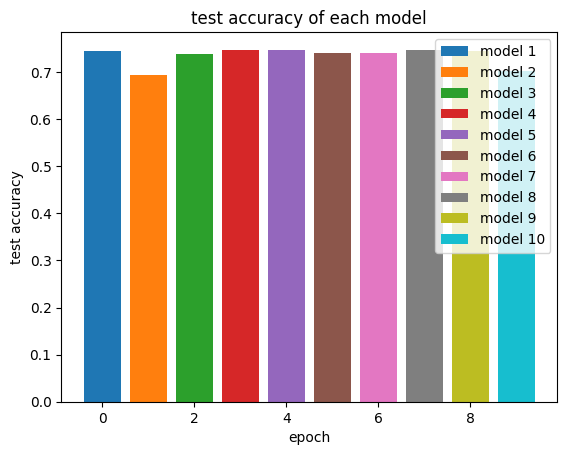

In [22]:
# plot each model's test accuracy in the same figure in bar chart
plt.figure()
for i in range(acc_data_matrix.shape[0]):
    plt.bar(i, acc_data_matrix[i, -1], label='model {}'.format(i+1))
plt.legend()
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.title('test accuracy of each model')
# plt.savefig(os.path.join(data_dir, 'test_acc.png'))
plt.show()

#### train_acc_matrix

In [23]:
train_acc_matrix = np.zeros((len(train_acc_files), epoch_num, 469))
for train_acc_file in train_acc_files:
    train_acc = np.load(train_acc_file, allow_pickle=True)
    print(train_acc.shape)
    train_acc_matrix[train_acc_files.index(train_acc_file),:, :] = train_acc
print(train_acc_matrix)

(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
[[[0.125      0.11328125 0.11979167 ... 0.51835185 0.51878005 0.51906667]]

 [[0.140625   0.1015625  0.1015625  ... 0.51303199 0.51343817 0.51381667]]

 [[0.0703125  0.0859375  0.08854167 ... 0.48685091 0.48737981 0.48778333]]

 ...

 [[0.109375   0.08984375 0.0859375  ... 0.52062701 0.52100027 0.52135   ]]

 [[0.1015625  0.09375    0.09114583 ... 0.49372658 0.49417401 0.49455   ]]

 [[0.0859375  0.08203125 0.0859375  ... 0.46895075 0.46935096 0.4697    ]]]


In [24]:
train_acc_avg = np.mean(train_acc_matrix, axis=2)
print(train_acc_avg)
    

[[0.33468964]
 [0.32835248]
 [0.29570617]
 [0.29221252]
 [0.28151732]
 [0.33477554]
 [0.29762606]
 [0.33426241]
 [0.30040123]
 [0.27873099]]


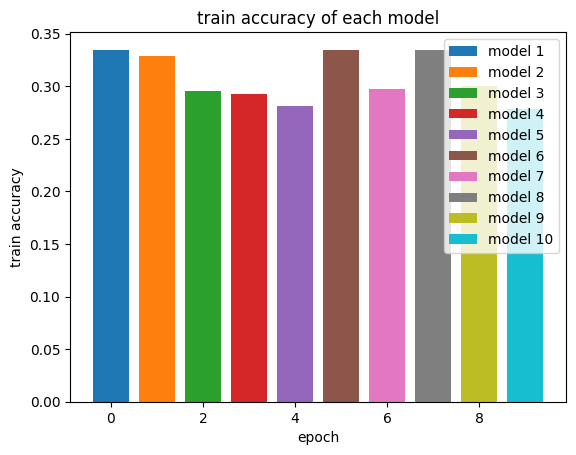

In [26]:
# plot each model's train accuracy in the same figure
plt.figure()
for i in range(train_acc_avg.shape[0]):
    plt.bar(i, train_acc_avg[i, -1], label='model {}'.format(i+1))
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train accuracy')
plt.title('train accuracy of each model')
# plt.savefig(os.path.join(data_dir, 'train_acc.png'))
plt.show()

#### train_l_matrix

In [27]:
train_l_matrix = np.zeros((len(train_l_files), epoch_num, 469))
for train_l_file in train_l_files:
    train_l = np.load(train_l_file, allow_pickle=True)
    print(train_l.shape)
    train_l_matrix[train_l_files.index(train_l_file),:, :] = train_l
print(train_l_matrix)

(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
(1, 469)
[[[2.29886556 2.30038667 2.29969962 ... 1.292401   1.29135493 1.29043347]]

 [[2.2995944  2.30267262 2.30154292 ... 1.30576333 1.30477254 1.30388272]]

 [[2.30200911 2.30392504 2.30422958 ... 1.38724312 1.38599365 1.38492281]]

 ...

 [[2.30540562 2.30716765 2.30794795 ... 1.28561672 1.2843749  1.2835706 ]]

 [[2.30387878 2.30578375 2.3049887  ... 1.35102716 1.34974571 1.3487596 ]]

 [[2.30324554 2.30489004 2.30396787 ... 1.44491589 1.4438017  1.44278408]]]


In [28]:
train_l_avg = np.mean(train_l_matrix, axis=2)
print(train_l_avg)

[[1.7947429 ]
 [1.80227773]
 [1.89699237]
 [1.91624128]
 [1.9198514 ]
 [1.8024139 ]
 [1.87201146]
 [1.7833371 ]
 [1.85757599]
 [1.95214803]]


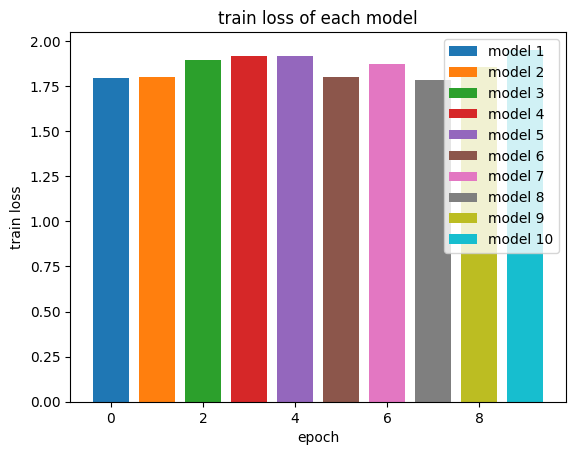

In [30]:
# plot each model's train loss in the same figure
plt.figure()
for i in range(train_l_avg.shape[0]):
    plt.bar(i, train_l_avg[i, -1], label='model {}'.format(i+1))
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('train loss of each model')
# plt.savefig(os.path.join(data_dir, 'train_loss.png'))
plt.show()

#### energy_data

In [31]:
energy_data_matrix = np.zeros((len(energy_data_files), epoch_num, 1), dtype=object)
for energy_data_file in energy_data_files:
    energy_data = np.load(energy_data_file, allow_pickle=True)
    # print(energy_data)
    energy_data_matrix[energy_data_files.index(energy_data_file),:, :] = energy_data
print(energy_data_matrix)

[[[list([7419, 8659, 9277, 9497, 10489, 8805, 9178, 8779, 9450, 9042, 9054, 9864, 9461, 11491, 10115, 11358, 11733, 10395, 11009, 10367, 10998, 11629, 10178, 9504, 9280, 9238, 10011, 10225, 8999, 13313, 14150, 10772, 9899, 9882, 10792, 10177, 9646, 10016, 10573, 10403, 9700, 9255, 9220, 8812, 11086, 10183, 12338, 9452, 10042, 9189, 9675, 9616, 10157, 9569, 9840, 9820, 10483, 9148, 9403, 9071, 9737, 9468, 9418, 9070, 9386, 9610, 9441, 9354, 8950, 9600, 9526, 9387, 9253, 8956, 9721, 9962, 11124, 10241, 8963, 9816, 9682, 9332, 9742, 9301, 10114, 9765, 9443, 8753, 9650, 9796, 9309, 9354, 9161, 9802, 10035, 9622, 9051, 9739, 10511, 9339, 9356, 8843, 9997, 10342, 9658, 10778, 10144, 10640, 9515, 9379, 8922, 9741, 9529, 9319, 9543, 8938, 10099, 9714, 9633, 9692, 8913, 9619, 11789, 9631, 8746, 9332, 9477, 9658, 9964, 9303, 9319, 9295, 9790, 9528, 9826, 15401, 9864, 10474, 9662, 9231, 9147, 9694, 9784, 9713, 9724, 9227, 9649, 10095, 9586, 9326, 9133, 9671, 9670, 9288, 9317, 9087, 9412, 9840, 93

In [32]:
energy_data_avg = np.zeros((energy_data_matrix.shape[0], energy_data_matrix.shape[1]))
for i in range(energy_data_matrix.shape[0]):
    devicei_energy = energy_data_matrix[i, :, :]
    for j in range(devicei_energy.shape[0]):
        devicei_energy_epochi = np.array(devicei_energy[j, :][0])
        # print(devicei_energy_epochi)
        devicei_energy_epochi_mean = np.mean(devicei_energy_epochi)    
        # print(devicei_energy_epochi_mean)
        energy_data_avg[i, j] = devicei_energy_epochi_mean    
print(energy_data_avg)
        
    

[[10146.99507389]
 [10092.67892157]
 [10518.61743341]
 [10787.29594272]
 [10850.25970874]
 [10257.14742015]
 [ 9601.09669811]
 [ 9492.8377724 ]
 [10475.70588235]
 [10319.77804878]]


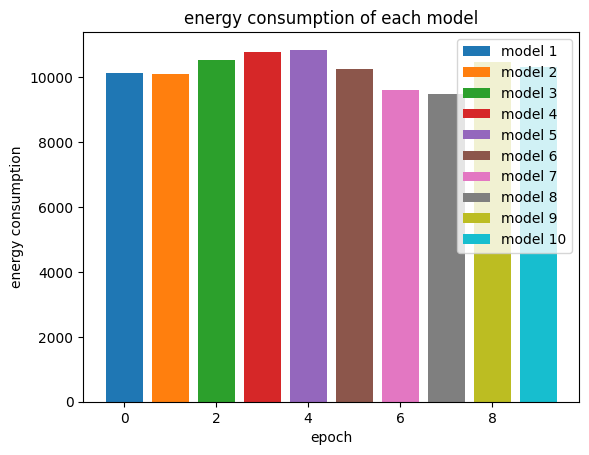

In [34]:
# plot each model's energy consumption in the same figure
plt.figure()
for i in range(energy_data_avg.shape[0]):
    plt.bar(i, energy_data_avg[i, -1], label='model {}'.format(i+1))
plt.legend()
plt.xlabel('epoch')
plt.ylabel('energy consumption')
plt.title('energy consumption of each model')
# plt.savefig(os.path.join(data_dir, 'energy_consumption.png'))
plt.show()